In [29]:
import json
import jsonpath
from tensorflow.keras.preprocessing.text import Tokenizer  #词向量化
from tensorflow.keras.preprocessing.sequence import pad_sequences  #序列矩阵

# 1、preprocess_data

In [30]:
path=r"/home/bdai/718/tensroflow2022/3_Word Vectorization/case/Sarcasm/data/Sarcasm_Headlines_Dataset.json"
with open(path,"r",encoding="utf-8")as f:
    data=f.readlines()
data=[eval(item)  for item in data]
sentence=[]
labels=[]
urls=[]
for i in range(len(data)):
    sentence.append(data[i]["headline"])
    labels.append(data[i]["is_sarcastic"])
    urls.append(data[i]["article_link"])

# 划分数据集

In [31]:
train_size=20000
max_length=32   #最大序列长度
padding_type="post"
truncating_type="post"
vocab_size=10000  #词典单词数量
embedding_dim=5

In [32]:
train_sentence=sentence[:train_size]
train_labels=labels[:train_size]
test_sentence=sentence[train_size:]
test_labels=labels[train_size:]
print(len(train_sentence))
print(len(train_labels))
print(len(test_sentence))
print(len(test_labels))

20000
20000
6709
6709


In [33]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token="oov")
tokenizer.fit_on_texts(train_sentence)  #构建词向量词典
#查看词典
word_index=tokenizer.word_index
#向量序列化,词矩阵
train_seq=tokenizer.texts_to_sequences(train_sentence)
#去除多余的0
train_pad=pad_sequences(train_seq,
                maxlen=max_length,
                padding=padding_type,  #选择将0放在后面
                truncating=truncating_type  #从尾部删除
                )  

#向量序列化,词矩阵
test_seq=tokenizer.texts_to_sequences(train_sentence)
#去除多余的0
test_pad=pad_sequences(train_seq,
                maxlen=max_length,
                padding=padding_type,  #选择将0放在后面
                truncating=truncating_type  #从尾部删除
                ) 

到这里，我们将句子转变为数字代替的矩阵，那么是如果确定这个句子情感呢？这里就涉及到了**embedding**了

# Word_Embedding

    tf.keras.layers.Embedding(
    input_dim,   #输入数据最大下标+1
    output_dim,  #每个数字转为的长度
    embeddings_initializer='uniform',  #嵌入矩阵的初始化方法，为预定义初始化方法名的字符串，或用于初始化权重的初始化器
    embeddings_regularizer=None,  #嵌入矩阵的正则项，为Regularizer对象 
    embeddings_constraint=None, #嵌入矩阵的约束项，为Constraints对象
    mask_zero=False,
    input_length=None,  #输入数据的维度
    **kwargs)


In [34]:
import tensorflow_datasets as tfds  #导入数据包
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [35]:
train_labels=np.array(train_labels)
test_labels=np.array(train_labels)

In [36]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,      #每条文字转为数字存储时候的最大长度
                            embedding_dim,    #将每个数字转为固定维度为16的向量
                            input_length=max_length      #列长
                            ),
    tf.keras.layers.Flatten(),  #全连接层
    #tf.keras.layers.GlobalAveragePooling1D(), #全局平均池化层，在每个维度的向量上取平均值进行输出
    tf.keras.layers.Dense(units=4,activation="relu"),
    tf.keras.layers.Dense(units=1,activation="sigmoid")
])

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()
hist=model.fit(train_pad,train_labels,epochs=10,validation_data=(test_pad,test_labels))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 32, 16)            160000    
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 4)                 2052      
                                                                 
 dense_21 (Dense)            (None, 1)                 5         
                                                                 
Total params: 162,057
Trainable params: 162,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4679 - accuracy: 0.7716 - val_loss: 0.2403 - val_accuracy: 0.9151
Epoch 2/10
625/625 [=================

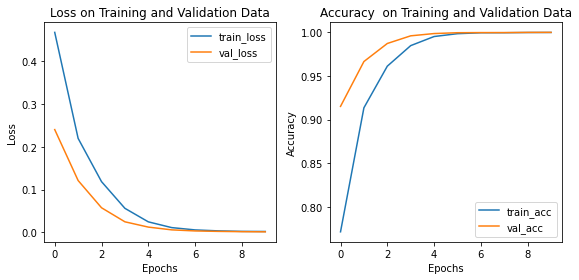

In [37]:
# define the function
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['accuracy']  # new version => hist.history['accuracy'] 
    val_acc = hist.history['val_accuracy'] #=> hist.history['val_accuracy'] 
    
    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

training_vis(hist)

# 模型测试

In [48]:
result=model.predict(test_pad[:10])
for i in range(10):
    if result[i]>0.5:
        print("这是讽刺标题")
    else:
        print("这不是讽刺标题")
print(test_labels[:10])

这不是讽刺标题
这不是讽刺标题
这是讽刺标题
这是讽刺标题
这不是讽刺标题
这不是讽刺标题
这不是讽刺标题
这不是讽刺标题
这是讽刺标题
这不是讽刺标题
[0 0 1 1 0 0 0 0 1 0]
